<a href="https://colab.research.google.com/github/hugo-degrossi/cesi_data_science/blob/main/demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Data Science, deliverables 1, 2 and 3
Groupe 2 - Maxime BAILLY-SALINS, Naomie ALBERT, Hugo DE GROSSI, Félix DUFAY


**Context** : We want to create a model that is able to generate captions on a photo. To do so, we were given 3 steps :
- Classify images among those which are pictures and those which are not (drawings, paintings...) in order to keep only pictures.
- Reduce image's noise with a denoiser.
- Generate a caption.

In this deliverable, most of the cells might not be executed. This is due to our choice of using google colab. We decided to use google colab because we realised our computers would not be able to train our AI fast enough.

In order to be able to work on several days, we also used google drive, allowing us to always have our datasets close to our google colab, no matter what internet connexion we have. Thus, a non-premium google drive is not able to handle all the datasets we used, explaining why it is complicated to execute all of the cells below.

#Conclusion
To conclude, we have an AI (a pipeline of 3 AI) that is able to sort images, keeping only pictures in a dataset, to reduce noise of these pictures, and to give a pretty accurate description of the content of the picture.

## Import & Vars

In [14]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import cv2

import pickle
import os
import time

from PIL import Image

In [16]:
MODEL_PATH = "/content/drive/MyDrive/final/models/"
VOCABULARY_PATH = "/content/drive/MyDrive/final/Vocabulary/tokenizer_voc.pkl"

CHECKPOINT_PATH = "/content/drive/MyDrive/final/checkpoint/"  # in drive

DEMO_PATH = "/content/drive/MyDrive/final/dataset/"

LIMIT_SIZE = 13000 

MAX_LENGTH = 50  # max word count for a caption
VOCABULARY_SIZE = 5000  # use the top x words for a vocabulary

## Utils

In [17]:
def load_all_images(datasets, img_height, img_width, max_images, base_path, grays):
    X = []
    y = []
    l = []
    for dataset in datasets:
        images_list = os.listdir(base_path + dataset['path'])
        loaded_images = []
        if grays:
          for idx, image in enumerate(images_list):
              l.append(base_path + dataset['path'] + '/' + image)
              img = tf.keras.preprocessing.image.load_img(
                      base_path + dataset['path'] + '/' + image,
                      target_size=(img_height, img_width),
                      color_mode="grayscale")
              X.append(np.asarray(img))
              y.append(dataset['name'])
              
              if (idx == max_images): break
        else:
          for idx, image in enumerate(images_list):
              l.append(base_path + dataset['path'] + '/' + image)
              img = tf.keras.preprocessing.image.load_img(
                      base_path + dataset['path'] + '/' + image,
                      target_size=(img_height, img_width))
              X.append(np.asarray(img))
              y.append(dataset['name'])
              
              if (idx == max_images): break
    return np.array(X), np.array(y), np.array(l)

def is_photo(labels, predicted):
  results = []
  for l in predicted:
    max_value = max(l)
    max_index = np.where(l == max_value)
    if labels[max_index[0][0]] == 'photo':
      results.append(True)
    else:
      results.append(False)
  return results

def plot_n(X, n):
  f, ax = plt.subplots(1,n)
  f.set_size_inches(10, 10)
  for i in range(n):
      ax[i].axis('off')
      ax[i].imshow(X[i])
  plt.show()

### Class

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    # Three dense layers to compute alignement score
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    """ 
    features = CNN_encoder's output (shape -> (batch_size, 64, embedding_dim) )
    hidden = current state from decoder (shape -> (batch_size, hidden_size) ) 
    """

    # hidden_with_time_axis.shape -> (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # This gives you an unnormalized score for each image feature
    score = self.V(attention_hidden_layer)  # calculate alignment score
    # score.shape -> (batch_size, 64, 1)

    
    # apply a softmax activation function to the alignment scores to obtain the attention weights
    attention_weights = tf.nn.softmax(score, axis=1)
     # attention_weights.shape -> (batch_size, 64, 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
class CNN_Encoder(tf.keras.layers.Layer):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    # And convert thoses features into two weights
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [20]:
class RNN_Decoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Gated Recurrent Unit
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    """ 
    x : current output of decoder
    features : output of encoder
    hidden : current state of decoder 
    """
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)  # predict next word

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    """ Reset decoder """
    return tf.zeros((batch_size, self.units))

In [21]:
class Captioner(tf.keras.Model):
    max_caption_length = 50
    embedding_dim = 256
    units = 512

    features_shape = 2048
    attention_features_shape = 64

    @staticmethod
    def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.keras.layers.Resizing(299, 299)(img)  # resize 299x299
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # normalize img for InceptionV3
        return img, image_path

    def __init__(
            self,
            tokenizer_vocabulary,
            encoder=None,
            decoder=None,
            optimizer=None
    ):
        super().__init__()

        self.vocabulary = tokenizer_vocabulary
        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=self.vocabulary
        )
        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=self.vocabulary,
            invert=True
        )

        image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                        weights='imagenet')
        new_input = image_model.input
        hidden_layer = image_model.layers[-1].output

        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

        self.encoder = encoder if encoder is not None else CNN_Encoder(self.embedding_dim)
        self.decoder = decoder if decoder is not None else RNN_Decoder(self.embedding_dim, self.units,
                                                                       len(self.vocabulary))
        self.optimizer = optimizer if optimizer is not None else tf.keras.optimizers.Adam()
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

        self.ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                        decoder=self.decoder,
                                        optimizer=self.optimizer)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, CHECKPOINT_PATH, max_to_keep=5)


    def load_last_checkpoint(self):
        if self.ckpt_manager.latest_checkpoint:
            print(f"Restoring {self.ckpt_manager.latest_checkpoint.split('-')}")
            self.ckpt.restore(self.ckpt_manager.latest_checkpoint)

    def evaluate(self, image):
        """ Evaluate function """
        attention_plot = np.zeros((self.max_caption_length, self.attention_features_shape))

        hidden = self.decoder.reset_state(batch_size=1)

        temp_input = tf.expand_dims(self.load_image(image)[0], 0)
        img_tensor_val = self.image_features_extract_model(temp_input)
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                     -1,
                                                     img_tensor_val.shape[3]))

        features = self.encoder(img_tensor_val)

        dec_input = tf.expand_dims([self.word_to_index('<start>')], 0)
        result = []

        for i in range(self.max_caption_length):
            predictions, hidden, attention_weights = self.decoder(dec_input,
                                                                  features,
                                                                  hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            predicted_word = tf.compat.as_text(self.index_to_word(predicted_id).numpy())
            result.append(predicted_word)

            if predicted_word == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

        attention_plot = attention_plot[:len(result), :]
        return result, attention_plot

    def loss_function(self, real, pred):
        """ Calculate loss function """
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_mean(loss_)

    @tf.function
    def train_step(self, img_tensor, target):
        loss = 0

        # initializing the hidden state for each batch
        # because the captions are not related from image to image
        hidden = self.decoder.reset_state(batch_size=target.shape[0])

        dec_input = tf.expand_dims([self.word_to_index('<start>')] * target.shape[0], 1)

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)

            for i in range(1, target.shape[1]):
                # passing the features through the decoder
                predictions, hidden, _ = self.decoder(dec_input, features, hidden)

                loss += self.loss_function(target[:, i], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))  # calculate loss

        # calculate gradient and apply to optimizer
        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


### Plot attention function

In [22]:
def plot_attention(image, result, attention_plot):
    """ Plot attention on image """
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Load Models

In [23]:
model_1 = tf.keras.models.load_model(MODEL_PATH+'delivrable_1.h5')
model_2 = tf.keras.models.load_model(MODEL_PATH+'delivrable_2.h5')

In [24]:
# Load model delivrable 3
tokenizer_vocabulary = None
if os.path.getsize(VOCABULARY_PATH) > 0:
    with open(VOCABULARY_PATH, "rb") as f:
        unpickler = pickle.Unpickler(f)
        tokenizer_vocabulary = unpickler.load()

if tokenizer_vocabulary:
  captioner = Captioner(tokenizer_vocabulary)
else:
  print("Vocabulary save not found.")

captioner.load_last_checkpoint()  # load last checkpoint

Restoring ['/content/drive/MyDrive/final/checkpoint/ckpt', '20']


## Load Data

In [33]:
base_path = "/content/drive/MyDrive/final/"

# all datasets and their labels
datasets = [
    {'name':'final', 'path':"dataset"},
]

# define an image size
img_height = 128
img_width = 128


n_images_per_class = 50

data_grays, labels, links = load_all_images(datasets, img_height, img_width, n_images_per_class, base_path, True)
data_color, labels, links = load_all_images(datasets, img_height, img_width, n_images_per_class, base_path, False)

data_grays = data_grays / 255
data_color = data_color / 255

## Demo !

In [29]:
labels_results = [
 'photo',
 'schematics',
 'sketch',
 'text'
]

img_height = 128
img_width = 128

1/1 [==============================] - 0s 61ms/step
We've found 4 photos for 15 images


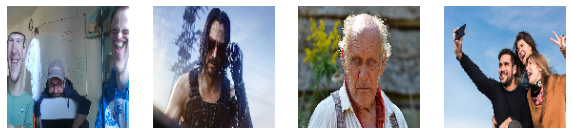

1/1 [==============================] - 0s 65ms/step
4 photos were denoised


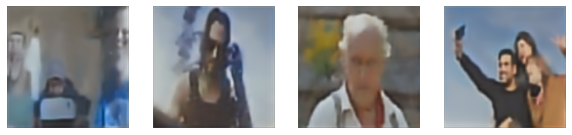

Prediction Caption: a couple of men standing next to a poster holding a picture of a man and a man and a man and a man and a man in a man's teeth with a [UNK] of a man and [UNK] a man's teeth of a man's teeth with a piece of
Prediction Caption: shot of a lady dressed up of a black and white image of a man is dressed up of a lady dressed up of a woman is dressed up of a black and white image of a cell phone wearing sunglasses on <end>
Prediction Caption: a man is talking on a tree. <end>
Prediction Caption: the ground view of men and a woman playing with a frisbee. <end>


In [34]:
# livrable 1 : check if photo
pred_1 = model_1.predict(data_grays)
pred_1 = is_photo(labels_results, pred_1)

photos_grays = data_grays[pred_1]
photos_color = data_color[pred_1]
links_photos = links[pred_1]

print(f"We've found {len(photos_grays)} photos for {len(data_grays)} images")
plot_n(photos_color, len(photos_color))

# livrable 2 : denoising
photos_denoised = model_2.predict(photos_color)
print(f"{len(photos_denoised)} photos were denoised")
plot_n(photos_denoised, len(photos_denoised))

# livrable 3 : captioning
for link in links_photos:
  result, attention_plot = captioner.evaluate(link)
  print('Prediction Caption:', ' '.join(result))